# Investigating the wind force influence
Comparing lake data with simulation with a model that is unaware of the wind and with one that is aware of it.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.test_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
model_loaders = catalog.load(f"{ship}.models")

[05/22/23 18:04:09] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=257826;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=871580;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/22/23 18:04:10] INFO     Kedro project phd                                                      ]8;id=836573;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=112954;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=513121;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=984615;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=72733;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=308147;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=329919;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=225749;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=305238;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=695611;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=572793;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=555647;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=607147;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=588964;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=420675;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=898402;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
time_series_meta_data

yaw     cog     sog  rudderTarget  rudderAngle   latitude  longitude  heelAngle  awaBow  awsBow  twaBow  twsBow  awaStern  awsStern  twaStern  twsStern  thrusterTarget  courseTarget  pitchAngle   GyroX   GyroY   GyroZ  AccelX  AccelY   AccelZ  awaBowRAW  awsBowRAW  twaBowRAW  twsBowRAW  awaSternRAW  awsSternRAW  twsSternRAW      delta       V       U       beta         u         v        psi     phi         r       u1d       v1d       r1d       y_GPS        x_GPS           x0          y0      aws        awa       tws       twa  zigzag_test_id  inbetween_zigzags_id                       date       type           time_series
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
0   4.6142  4.5255  2.4869       12.2867      12.3059  59.291708  18.324195     0.0556  0.4431  2.3618  3.1333  1.2123    0.5961    2.5882    3.1356    1.1035           100.0        3.1556      0.0261  0.1161  0.0359  0.1113  0.2998  1.1207  10.4167     0.5236     2.5156     3.1387     1.3705       0.6458       2.8809        1.2000  0.214778  2.4869  2.4869   6.585485  2.447543  0.661586  10.897385  0.0556  0.113965  0.228417  0.523831  0.211835  339.869303  1387.282236  1384.530613  339.744214  2.54650   0.544550  1.038471  6.275854             0.0                   NaN 2021-04-28 10:27:01.224843     zigzag  motoring_7m_all_data
1   3.5568  3.6466  2.3885       12.5921      12.5381  59.283688  18.323452     0.0613  0.8018  7.9267  1.2375  5.6938    0.7847    7.7081    1.2010    5.4819           100.0        3.1416      0.0168  0.1171  0.0458  0.1139  0.2819  0.9820  10.5981     0.9425     8.5390     1.3664     6.2561       0.8727       8.1744        5.9537  0.218831  2.3885  2.3885   6.639285  2.388489  0.714082  22.768641  0.0613  0.127475  0.481107  1.018159  0.299873  290.883099   494.211045   491.438685  293.171998  7.93505  19.206806  5.660067  2.920341             1.0                   NaN 2021-04-28 10:41:19.614095     zigzag  motoring_7m_all_data
2   6.2807  6.2821  2.2624       12.7166      12.7703  59.287654  18.323811     0.0995  3.1400  2.4178  3.1410  3.0032    3.1406    2.1305    3.1409    3.0415            80.0        6.1087      0.0184  0.2811  0.0477  0.1028  0.2036  0.9736  10.6415     3.1241     2.7780     3.1409     3.3802       3.1346       2.6534        3.3126  0.222884  2.2624  2.2624   6.652171  2.215301  0.739841  25.621227  0.0995  0.111463  0.287604  1.433933  0.215152  314.133968   935.785387   938.530517  313.316988  2.64750  29.758927  3.297912  3.327346             2.0                   NaN 2021-04-28 10:49:38.207640     zigzag  motoring_7m_all_data
3   6.2830  6.2784  2.1663       11.0927      11.1450  59.291236  18.323118     0.0583  3.1089  2.2336  3.1415  3.1125    3.1321    2.2329    3.1409    3.1128            80.0        6.1087      0.0165  0.1085  0.0277  0.0903  0.2002  0.8505  10.3556     3.1241     2.6274     3.1416     3.3891       3.1241       2.5722        3.4658  0.194517  2.1663  2.1663   6.540571  2.155465  0.677368  26.242827  0.0583  0.095506  0.189455  0.620825  0.164994  277.327323  1335.369789  1336.153454  276.196644  2.57220  31.293627  3.191869  3.206921             3.0                   NaN 2021-04-28 10:53:07.004897     zigzag  motoring_7m_all_data
4   6.2822  6.2827  1.7833       13.4409      13.4669  59.294757  18.321307     0.0405  3.1339  3.0136  3.1390  4.4613    3.1405    3.4860    3.1414    4.8217            60.0     

In [6]:
model_no_wind = model_loaders['vmm_abkowitz_diminished']()
model_wind = model_loaders['vmm_abkowitz_diminished_wind']()


In [7]:
model_wind.control_keys = ['delta','awa','aws']

In [8]:
#ship_data['A_YV']=0.5*6.037

In [9]:
mask = time_series_meta_data['type'] == 'zigzag'
time_series_meta_data_select = time_series_meta_data.loc[mask].sort_values(by='date')


results_no_wind = {}
results_wind = {}

for id, row in time_series_meta_data_select.iterrows():
    loader = time_series[id]
    
    data_raw = loader()
    #data_raw = fix_interpolated_angle(data=data_raw, key="awa", max_change=1.40)
        
    data = load(raw_data=data_raw)
    data.drop(columns=['mission','date'], inplace=True)
    #data['delta'] = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
    try:
        result_no_wind = model_no_wind.simulate(data)
    except:
        log.error(f"Failed to simulate model_no_wind for: {id}")
    else:
        df_result_no_wind = result_no_wind.result.copy()
        results_no_wind[id] = df_result_no_wind
    
    try:
        result_wind = model_wind.simulate(data)
    except:
        log.error(f"Failed to simulate model_wind for: {id}")
    else:
        df_result_wind = result_wind.result.copy()
        results_wind[id] = df_result_wind
    
    
    #data.plot(y='delta')
    #
    #dataframes = {
    #'Experiment':mean(data.rolling(2)),
    #'no_wind' : df_result_no_wind,
    #'wind' : df_result_wind
    #    
    #}
    #time_window=[0, np.inf]
    #ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
    #             time_window=time_window, N=10);
    #ax.legend(loc='upper right')

    
    

In [10]:
catalog.save(f"{ ship }.simulation_no_wind", results_no_wind)
catalog.save(f"{ ship }.simulation_wind", results_wind)

[05/22/23 18:05:50] INFO     Saving data to '7m.simulation_no_wind' (PartitionedDataSet)...     ]8;id=957493;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=967175;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

[05/22/23 18:05:51] INFO     Saving data to '7m.simulation_wind' (PartitionedDataSet)...        ]8;id=921510;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=279098;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [11]:
subs = [
(u,0),
(v,0),
(r,0),
(delta,0),
(u1d,0),
(v1d,0),
(r1d,0),  
]
lambda_F_Wx = lambdify(model_wind.X_eq.rhs.subs(subs))
lambda_F_Wy = lambdify(model_wind.Y_eq.rhs.subs(subs))
lambda_M_Wz = lambdify(model_wind.N_eq.rhs.subs(subs))


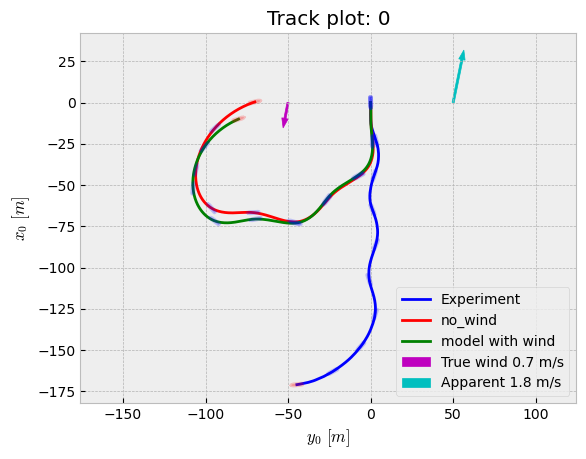

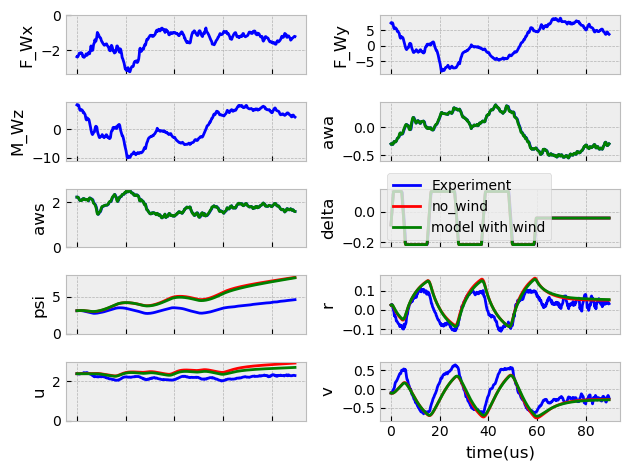

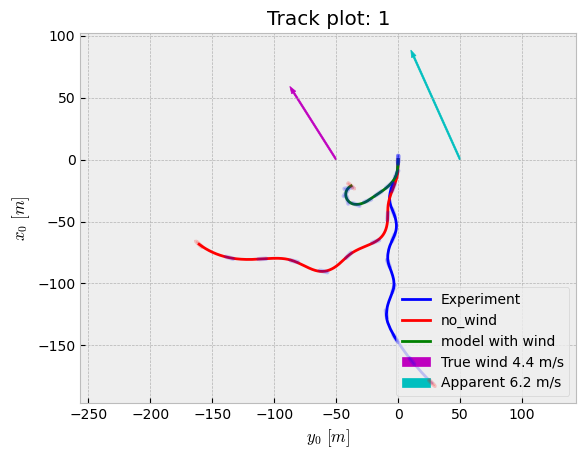

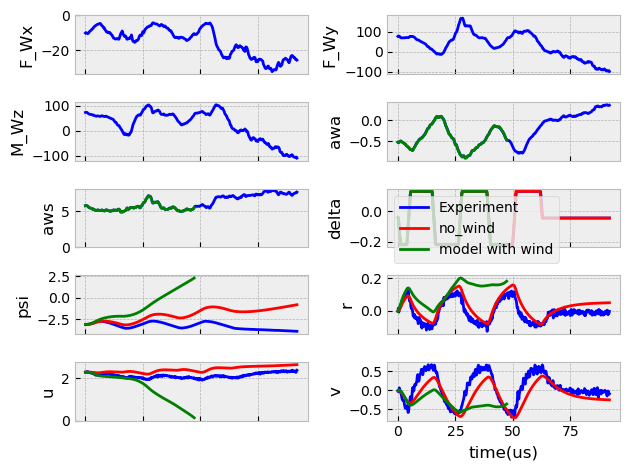

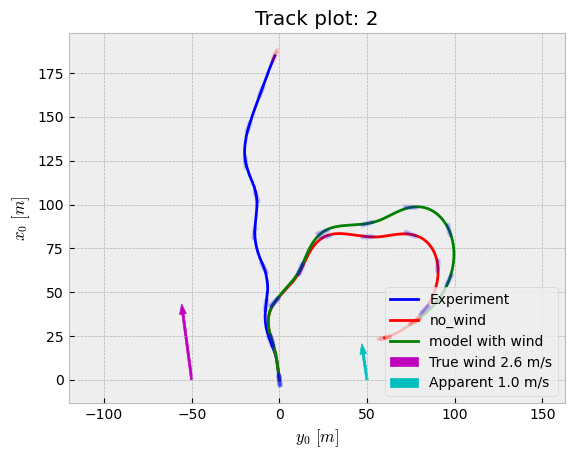

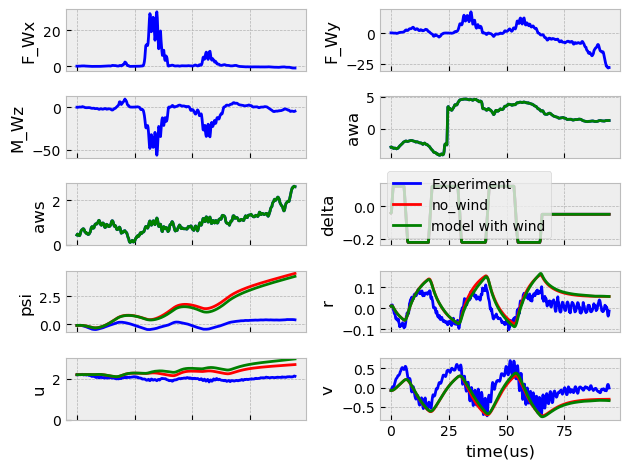

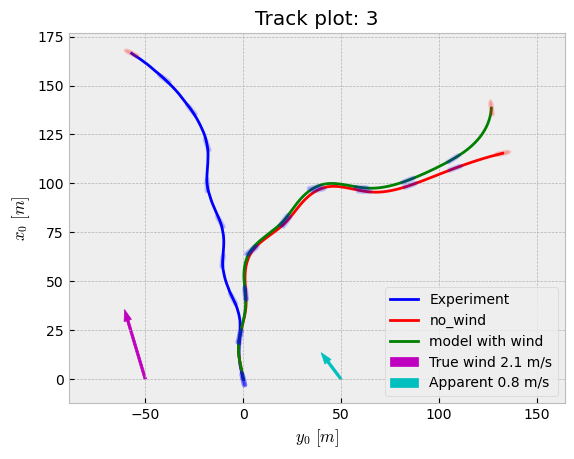

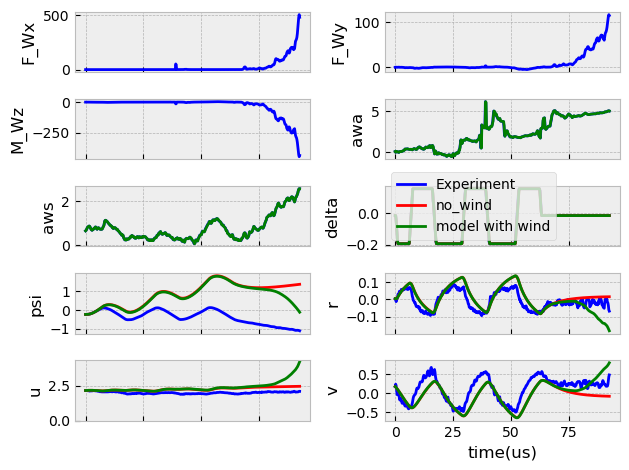

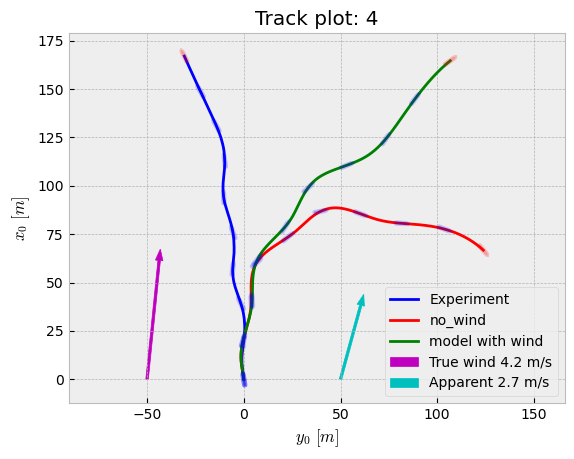

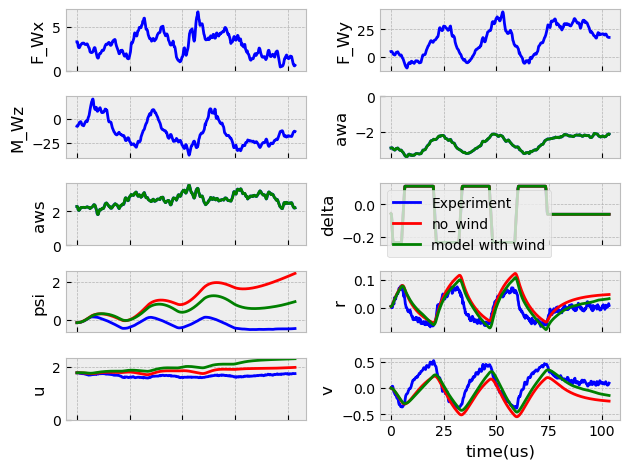

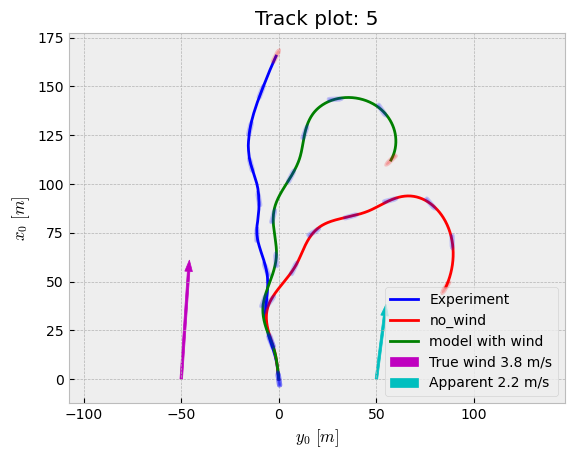

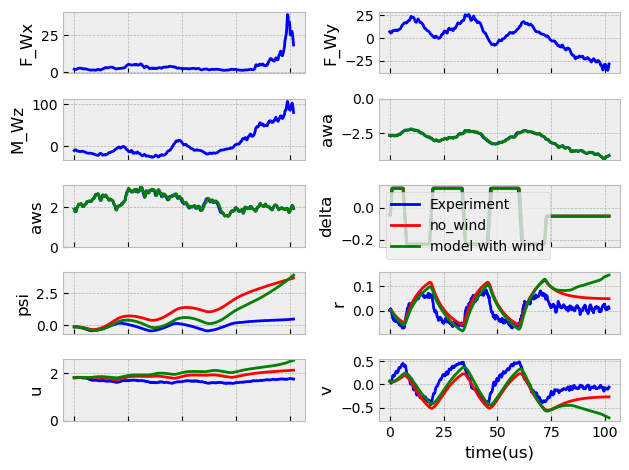

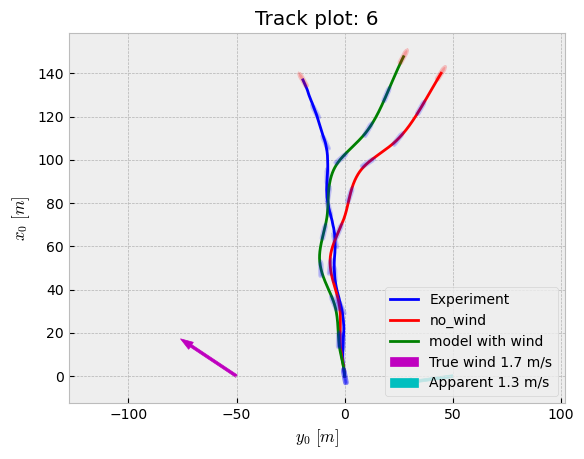

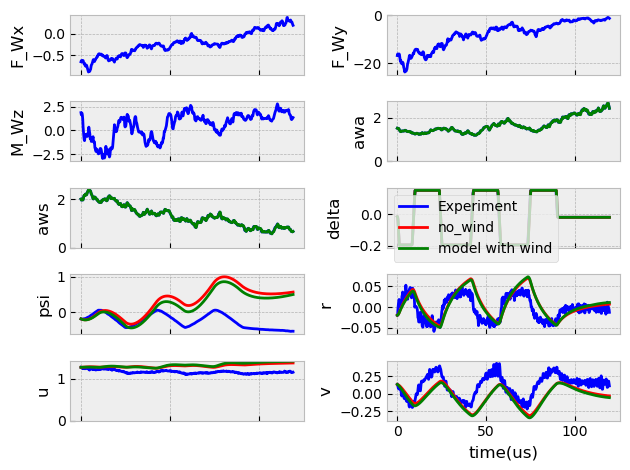

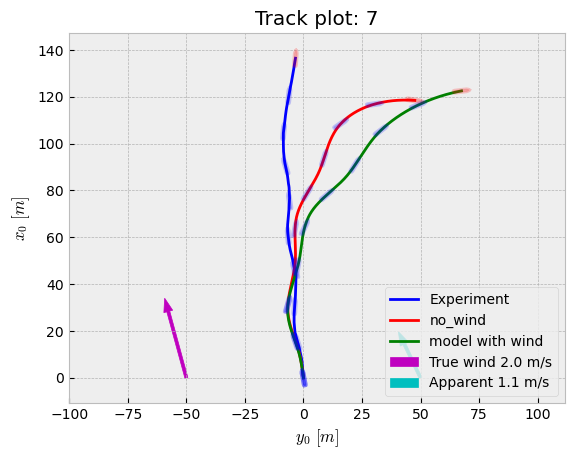

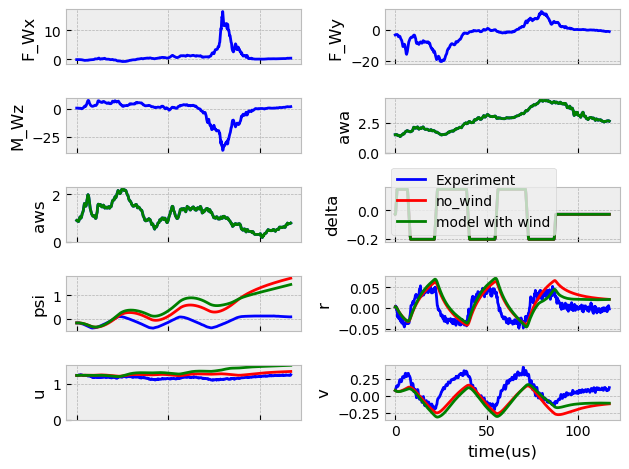

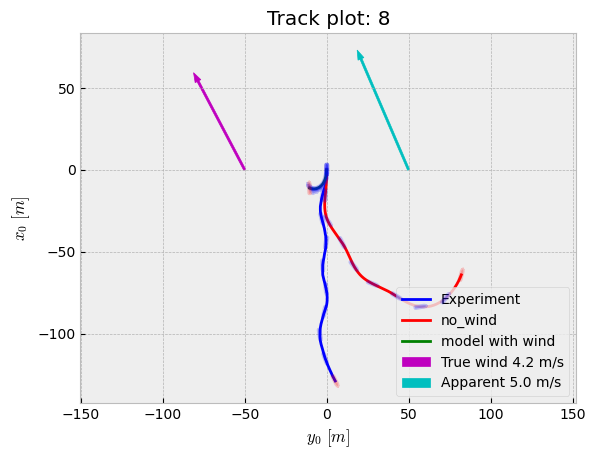

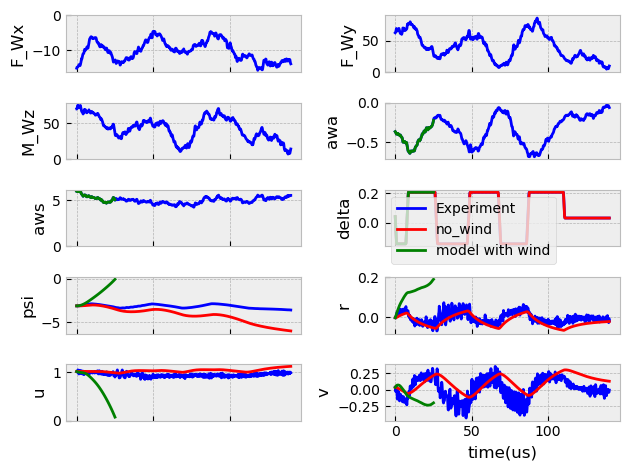

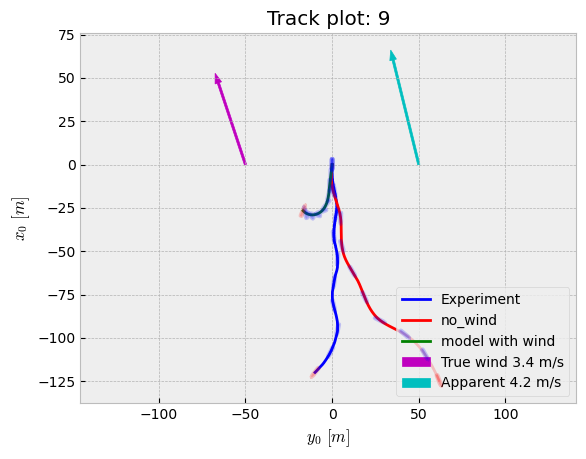

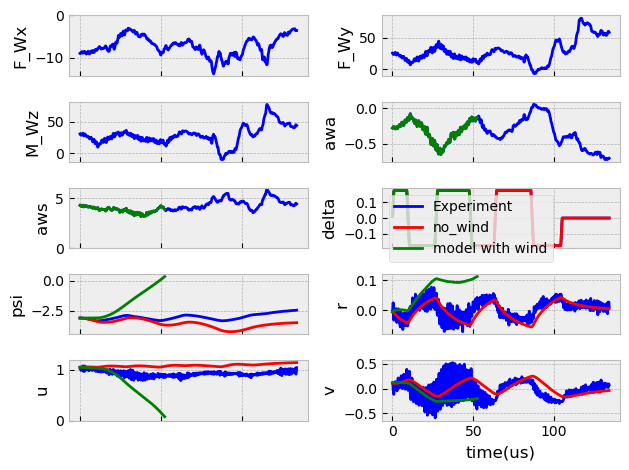

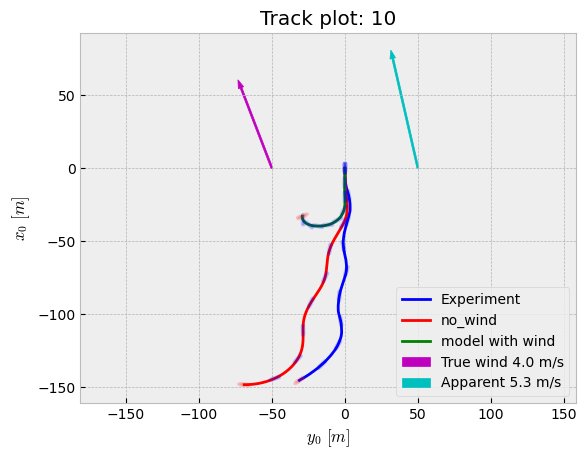

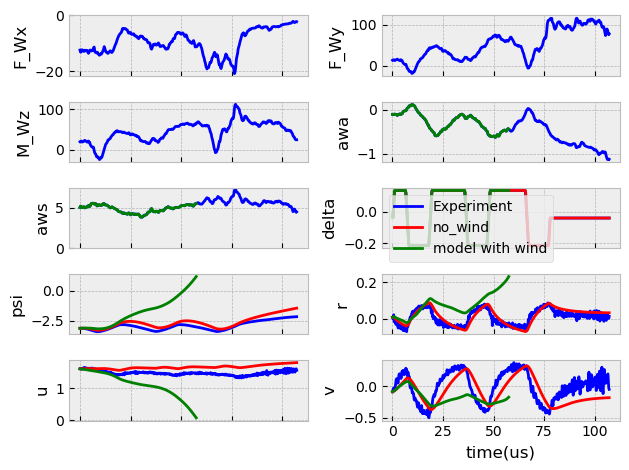

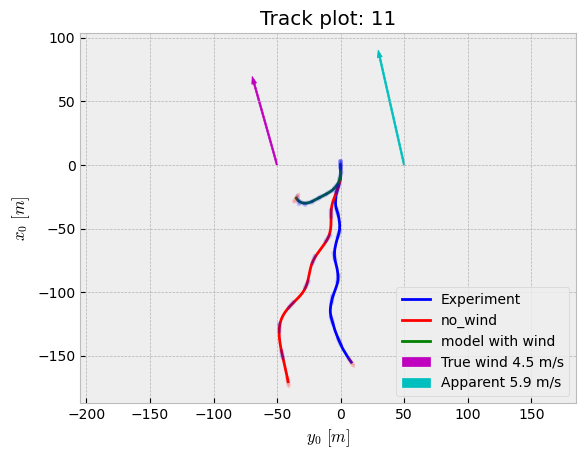

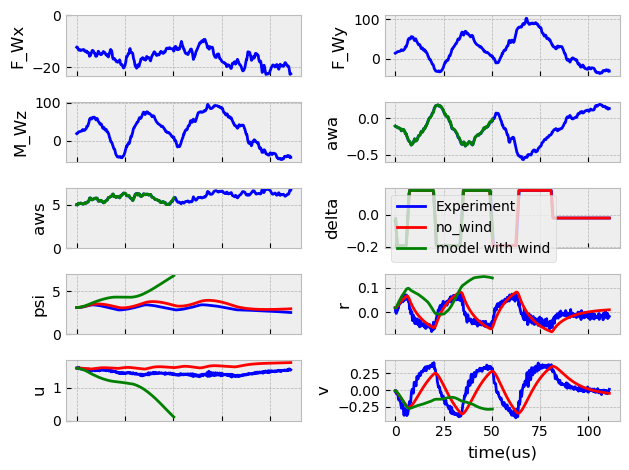

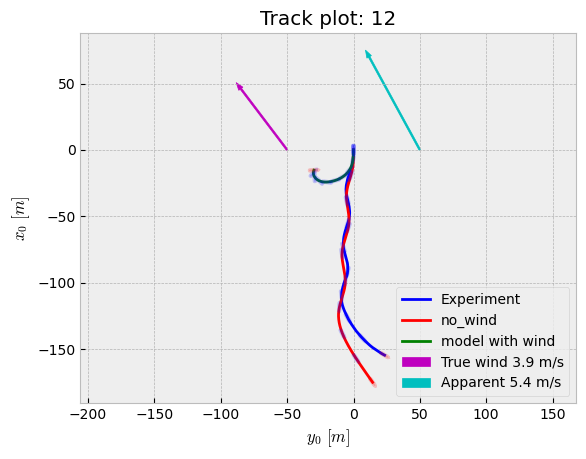

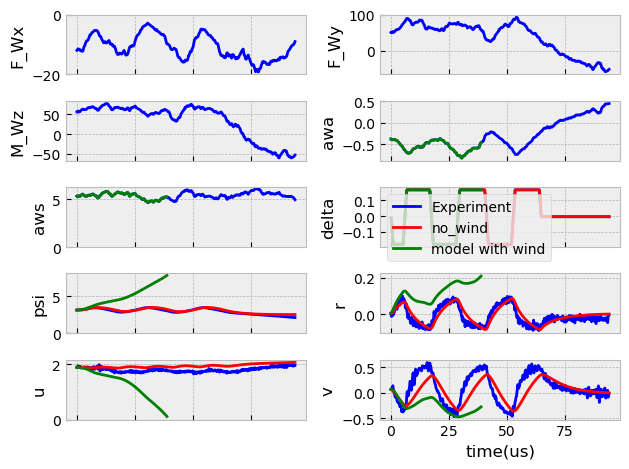

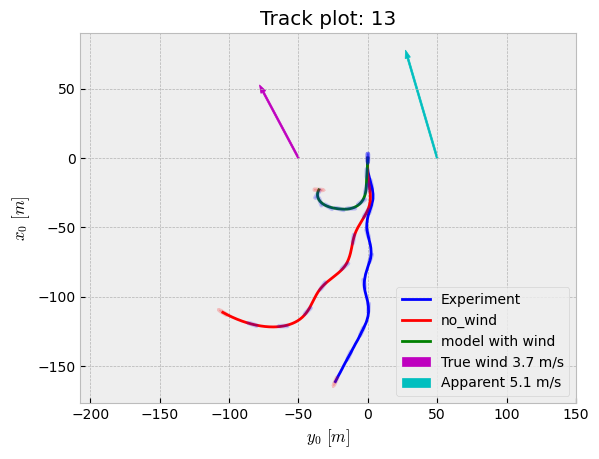

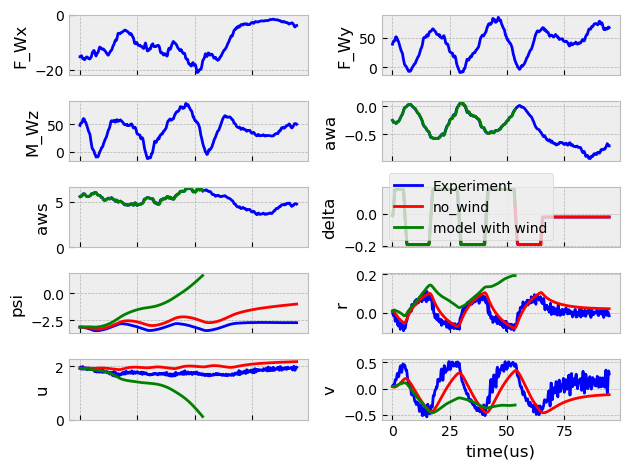

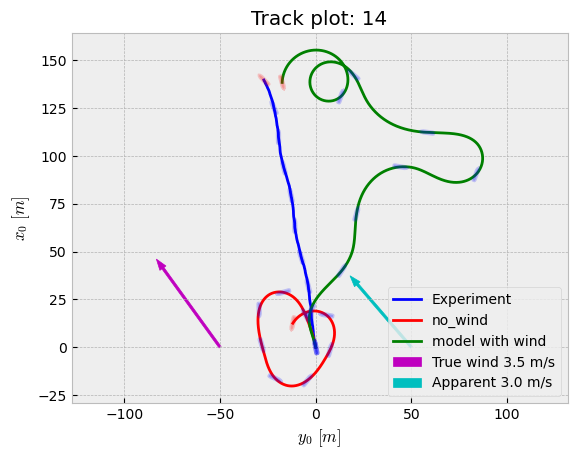

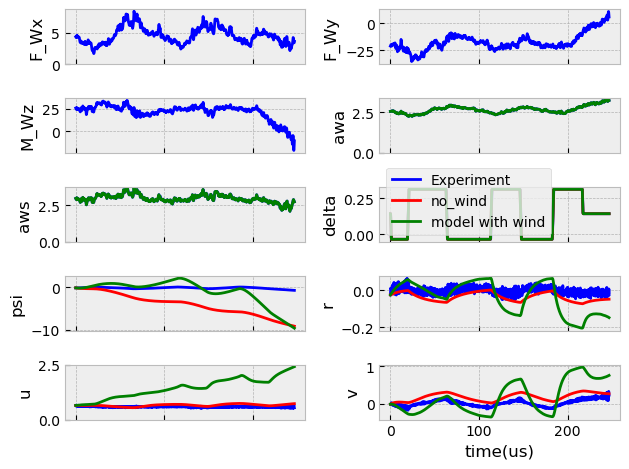

In [12]:
for id, row in time_series_meta_data_select.iterrows():
    
    loader = time_series[id]
    data_raw = loader()
    data = load(raw_data=data_raw)
    
    dataframes = {
    'Experiment':data,       
    }
    
    if id in results_no_wind:
        dataframes['no_wind'] = results_no_wind[id]
    
    if id in results_wind:
        results_wind['F_Wx'] = run(lambda_F_Wx, inputs=results_wind[id], **ship_data, **model_wind.parameters)
        results_wind['F_Wy'] = run(lambda_F_Wy, inputs=results_wind[id], **ship_data, **model_wind.parameters)
        results_wind['M_Wz'] = run(lambda_M_Wz, inputs=results_wind[id], **ship_data, **model_wind.parameters)
        dataframes['model with wind'] = results_wind[id]
            
    time_window=[0, np.inf]
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);
    ax.legend(loc='lower right')
    ax.set_title(f'Track plot: {id}') 
    
    
    data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
    data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
    data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)

    #fig,axes=plt.subplots(nrows=4)
    #df_result_wind.plot(y='awa', style='k', ax=axes[0])
    #df_result_wind.plot(y='F_Wx', style='r', ax=axes[1])
    #df_result_wind.plot(y='F_Wy', style='g', ax=axes[2])
    #df_result_wind.plot(y='M_Wz', style='b', ax=axes[3])
    
    plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','F_Wx','F_Wy','M_Wz'], time_window=time_window);
    

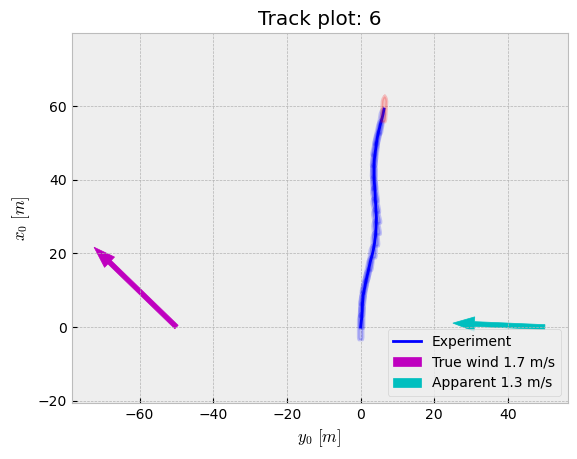

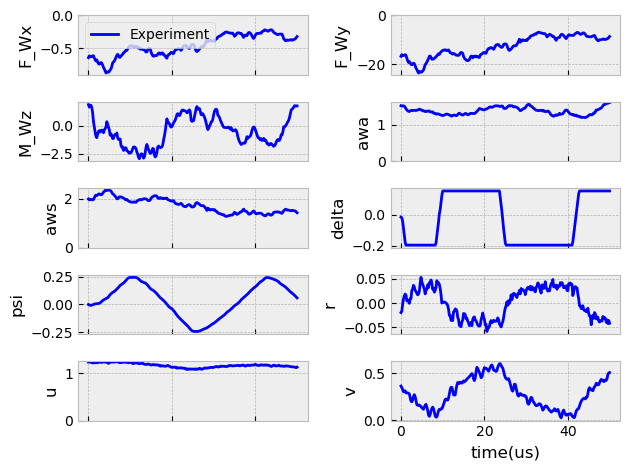

In [13]:
id = '6'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)

data['awa'] = smallest_signed_angle(data['awa'])
data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)


psi0 = -data['psi'].iloc[0].copy()
data['psi']+=psi0
data['cog']+=psi0
data['twa']+=psi0

x0 = data['x0']
y0 = data['y0']
data['x0'] = x0*np.cos(psi0) - y0*np.sin(psi0)
data['y0'] = x0*np.sin(psi0) + y0*np.cos(psi0)

u = data['u']
v = data['v']
data['u'] = u*np.cos(psi0) - v*np.sin(psi0)
data['v'] = u*np.sin(psi0) + v*np.cos(psi0)

dataframes = {
    'Experiment':data,
}

time_window=[0,50]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','F_Wx','F_Wy','M_Wz'], time_window=time_window);
    

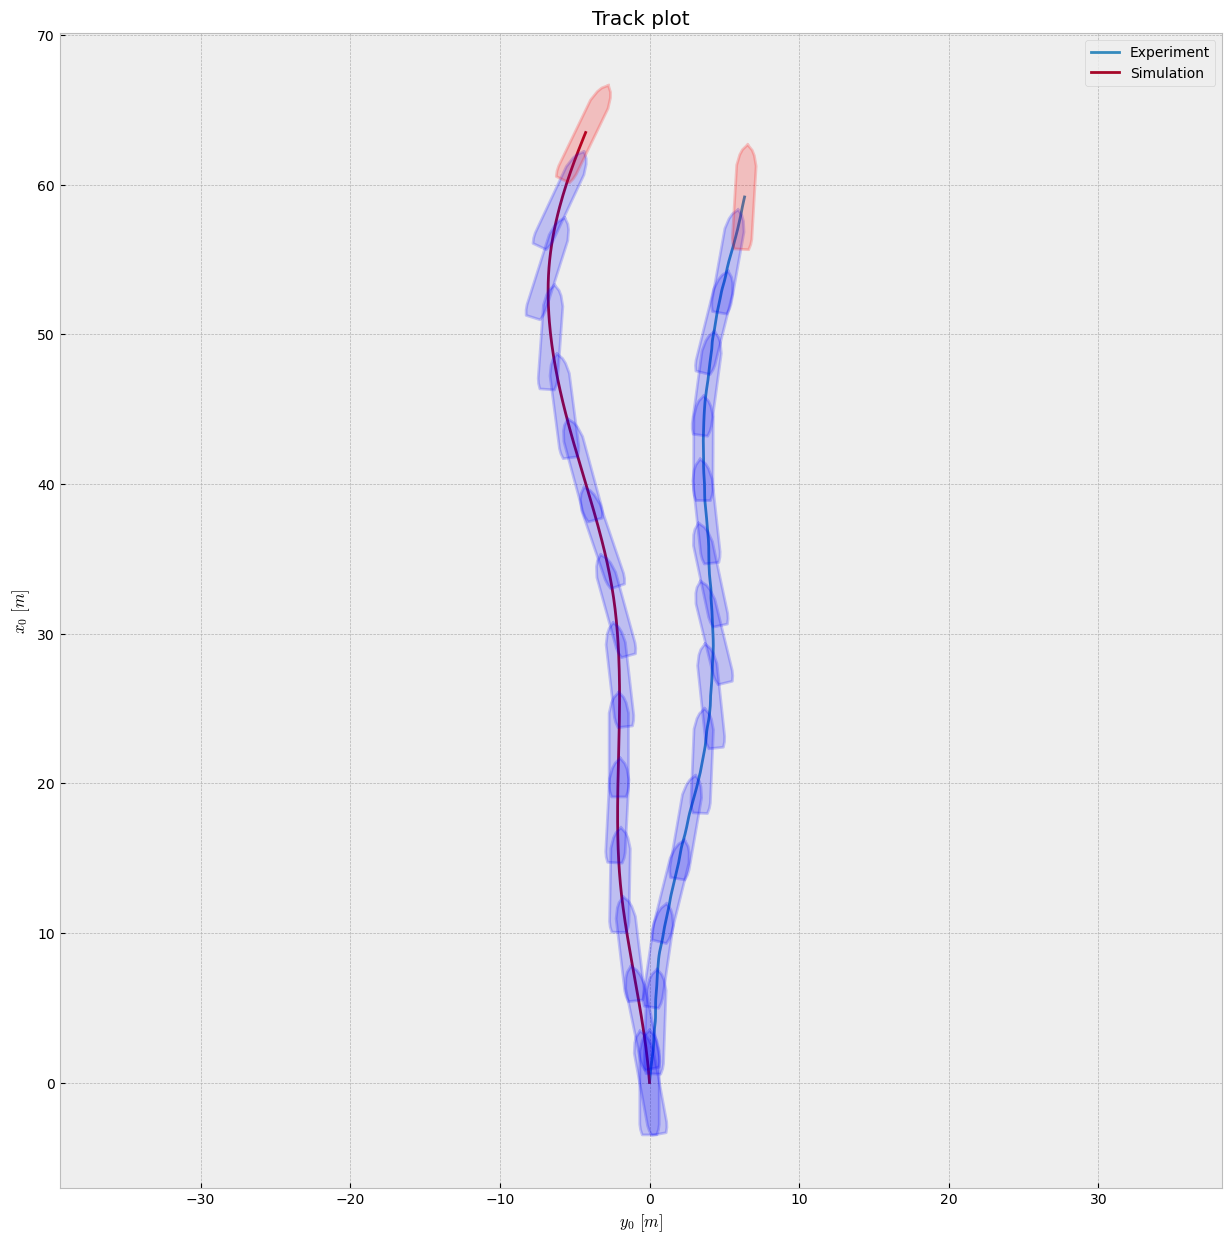

In [35]:
ax = track_plot(data, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15, label='Experiment')

track_plot(results_no_wind[id], lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15, label='Simulation', ax=ax)




ax.set_aspect("equal")
fig = ax.get_figure()
fig.set_size_inches(15,15)

In [15]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [16]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=model_no_wind.parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [17]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.3
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)                                         
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes['P_prd'][3][3]/=1000

In [18]:
x0 = initial_state(data)
#x0['v'] = 0.5

In [19]:
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=model_no_wind.parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=model_no_wind.parameters)

<Axes: xlabel='time(us)'>

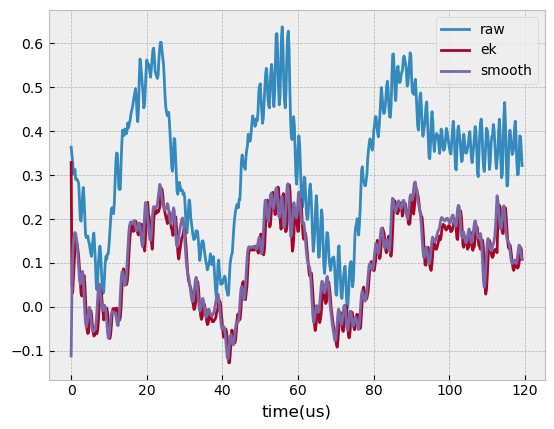

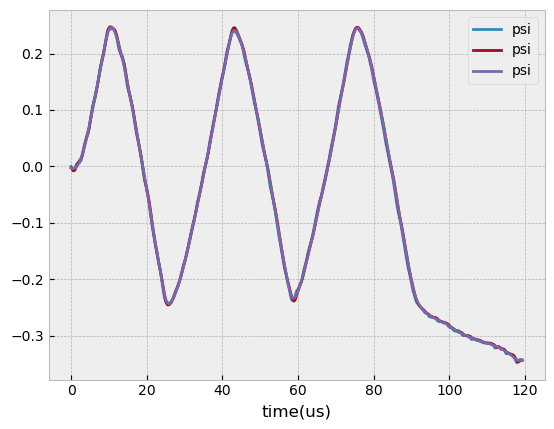

In [20]:
fig,ax=plt.subplots()
data.plot(y='v', label='raw', ax=ax)
data_ek.plot(y='v', label='ek', ax=ax)
data_ek_smooth.plot(y='v', label='smooth', ax=ax)
ax.legend()

fig,ax=plt.subplots()
data.plot(y='psi', ax=ax)
data_ek.plot(y='psi', ax=ax)
data_ek_smooth.plot(y='psi', ax=ax)

In [21]:
#data_ek_smooth['v'] = -0.5
result_no_wind = model_no_wind.simulate(data_ek_smooth)

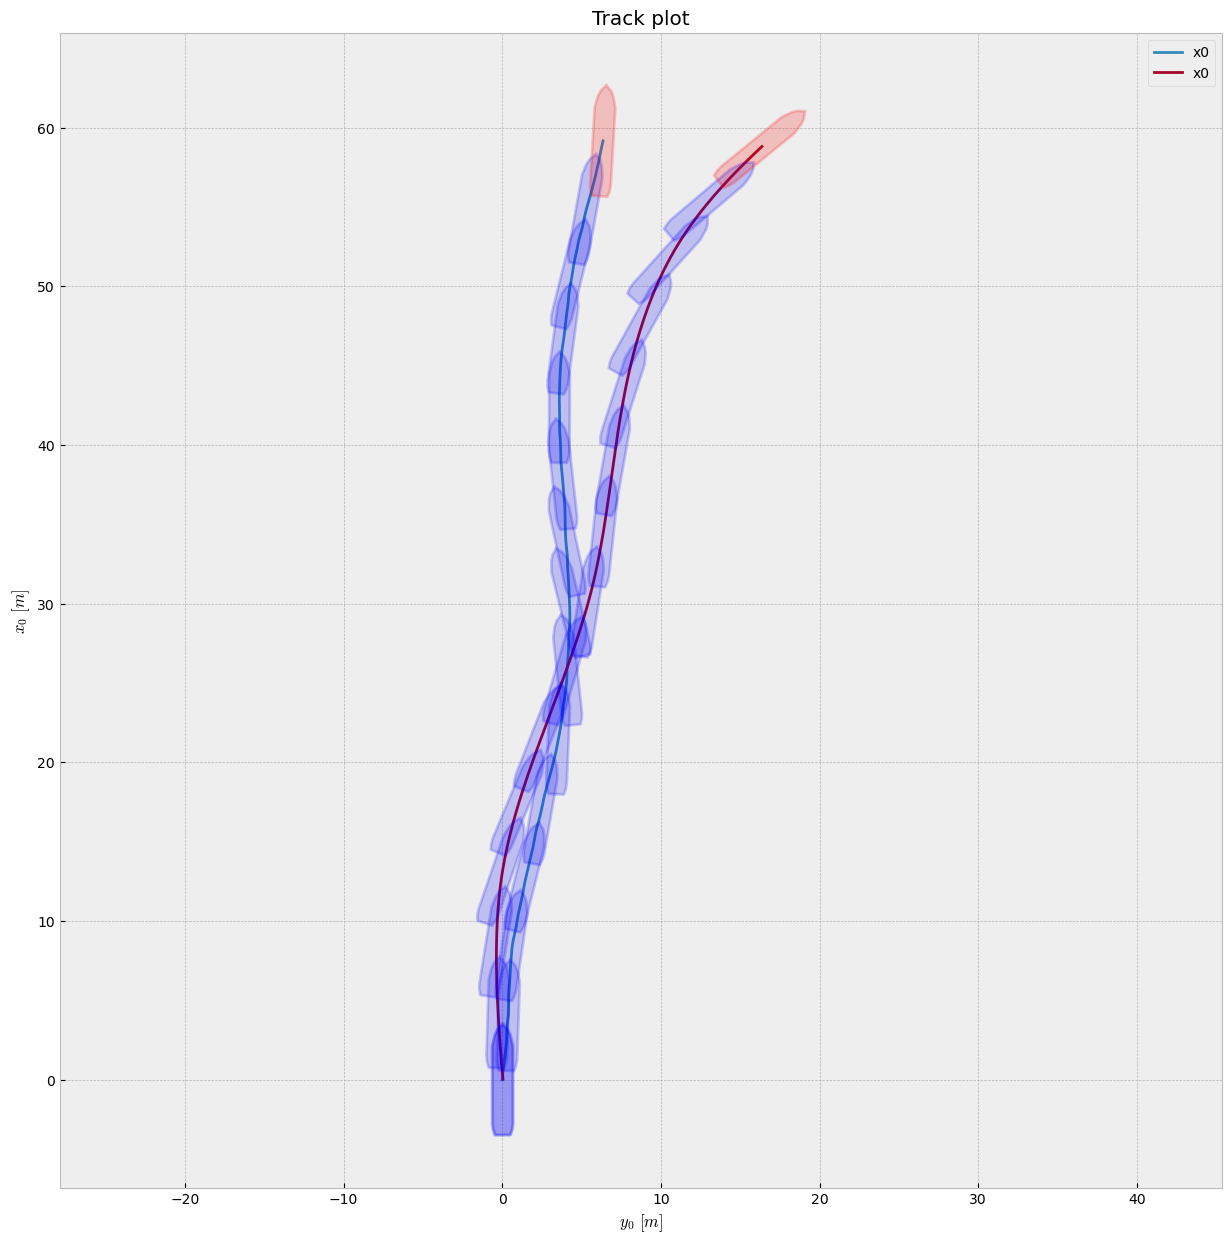

In [22]:
ax = track_plot(data, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15)

track_plot(result_no_wind.result, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15, ax=ax)




ax.set_aspect("equal")
fig = ax.get_figure()
fig.set_size_inches(15,15)

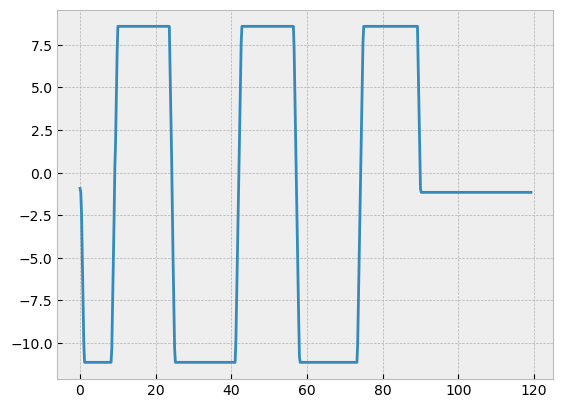

In [23]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['delta']))

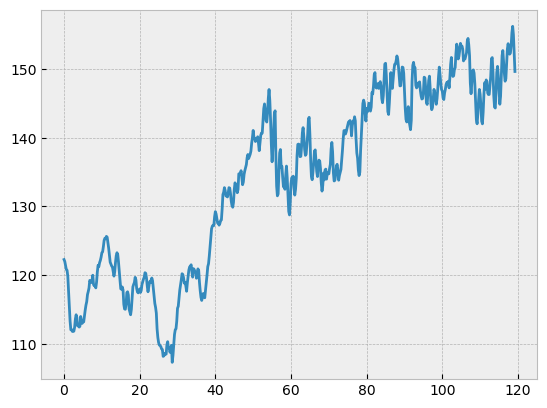

In [24]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['twa']))

In [25]:
np.rad2deg(mean_angle(data['twa']))

134.08785739863586

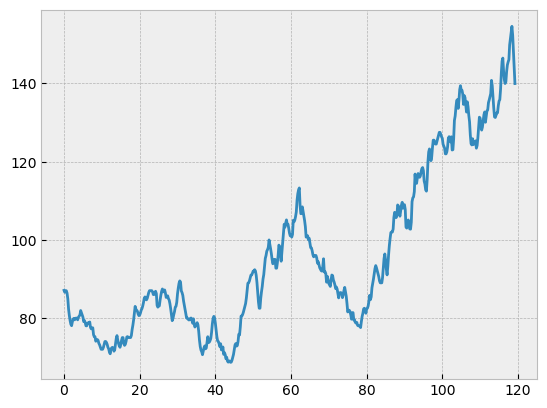

In [26]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['awa'] - (data.iloc[0]['awa'] - smallest_signed_angle(data.iloc[0]['awa']))))

In [27]:
data['V'].mean()

1.1844605704697986

<Axes: xlabel='time(us)'>

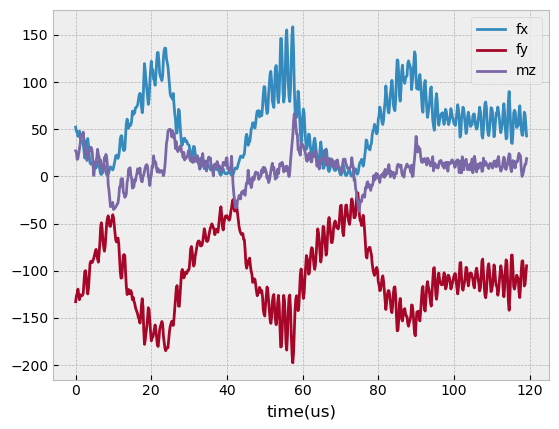

In [28]:
model_wind.forces(inputs=data[['u','v','V','r','delta','awa','aws']]).plot()

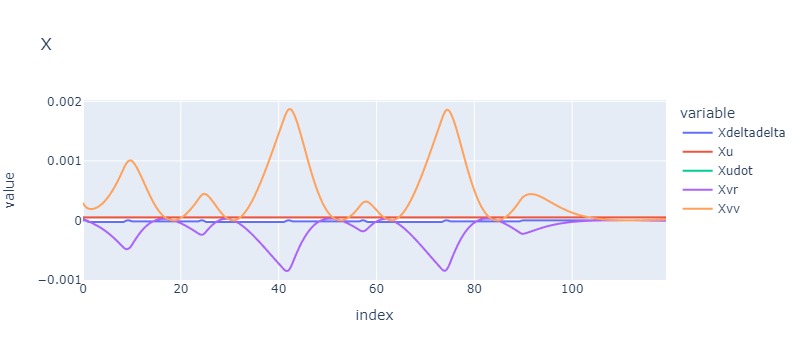

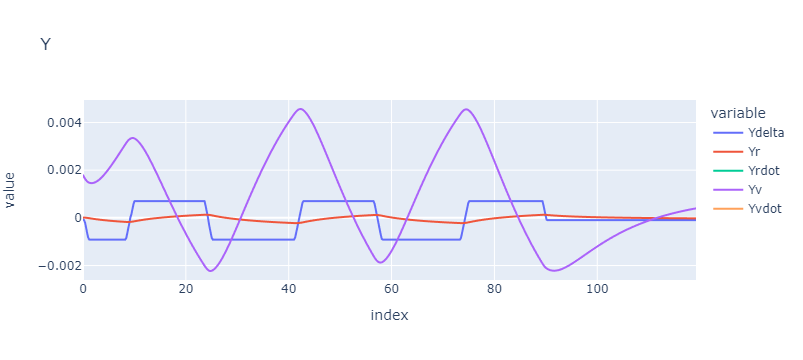

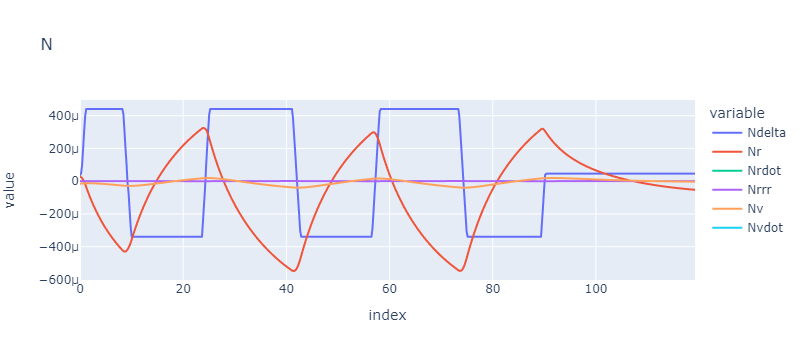

In [29]:
result_no_wind.plot_parameter_contributions(to_mlflow=False)

In [30]:
X_forces, Y_forces, N_forces = result_no_wind.simulate_parameter_contributions()

<Axes: >

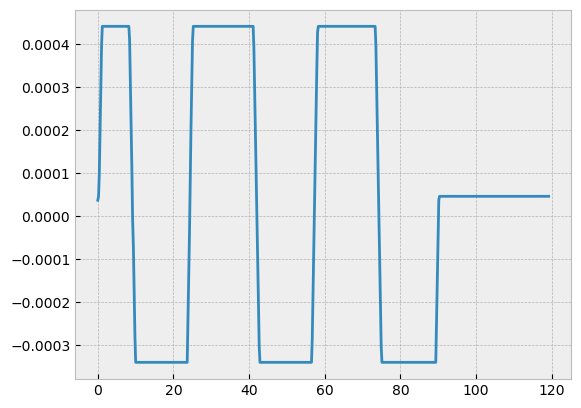

In [31]:
mask = N_forces.columns.str.contains('delta')
columns = N_forces.columns[mask]
N_forces[columns].sum(axis=1).plot()

In [32]:
units = {column:'moment' for column in N_forces.columns}

In [33]:
N = model_wind.prime_system.df_unprime(N_forces, U=result_no_wind.result['U'], units=units)

<Axes: >

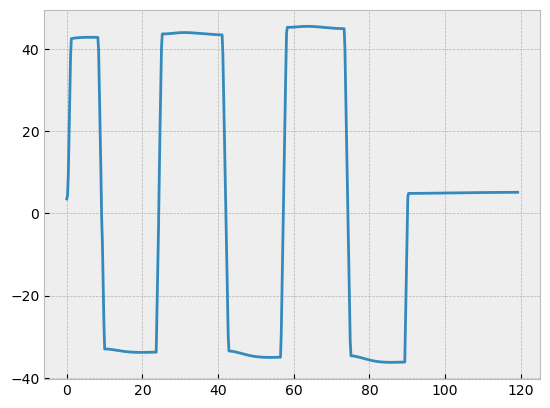

In [34]:
N[columns].sum(axis=1).plot()